In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import math

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

class DifferentialAttention(nn.Module):
    """
    Differential Attention as described in the Differential Transformer paper
    Following the pseudocode:
    
    def DiffAttn(X, W_q, W_k, W_v, λ):
        Q1, Q2 = split(X @ W_q)
        K1, K2 = split(X @ W_k)
        V = X @ W_v
        # Qi, Ki: [b, n, d]; V: [b, n, 2d]
        s = 1 / sqrt(d)
        A1 = Q1 @ K1.transpose(−1, −2) ∗ s
        A2 = Q2 @ K2.transpose(−1, −2) ∗ s
        return (softmax(A1) − λ softmax(A2)) @ V
    """
    def __init__(self, d_model, d_head, lambda_val=0.5):
        super(DifferentialAttention, self).__init__()
        self.d_head = d_head
        self.scale = 1.0 / math.sqrt(d_head)
        self.lambda_val = lambda_val
        
        # Single projections that will be split into positive/negative parts
        self.q_proj = nn.Linear(d_model, d_head * 2)
        self.k_proj = nn.Linear(d_model, d_head * 2)
        self.v_proj = nn.Linear(d_model, d_head)
    
    def forward(self, x, mask=None):
        # Project and split query and key
        q = self.q_proj(x)  # [batch, seq_len, d_head*2]
        k = self.k_proj(x)  # [batch, seq_len, d_head*2]
        v = self.v_proj(x)  # [batch, seq_len, d_head]
        
        # Split into positive and negative parts
        q1, q2 = torch.chunk(q, 2, dim=-1)  # [batch, seq_len, d_head]
        k1, k2 = torch.chunk(k, 2, dim=-1)  # [batch, seq_len, d_head]
        
        # Calculate attention scores
        attn_scores1 = torch.matmul(q1, k1.transpose(-2, -1)) * self.scale
        attn_scores2 = torch.matmul(q2, k2.transpose(-2, -1)) * self.scale
        
        # Apply mask if provided
        if mask is not None:
            attn_scores1 = attn_scores1.masked_fill(mask == 0, -1e9)
            attn_scores2 = attn_scores2.masked_fill(mask == 0, -1e9)
        
        # Apply softmax to get attention weights
        attn_weights1 = F.softmax(attn_scores1, dim=-1)
        attn_weights2 = F.softmax(attn_scores2, dim=-1)
        
        # Calculate differential attention (positive - λ*negative)
        diff_attn = attn_weights1 - self.lambda_val * attn_weights2
        
        # Apply attention to values
        output = torch.matmul(diff_attn, v)
        
        return output

class MultiHeadDifferentialAttention(nn.Module):
    """
    Multi-Head Differential Attention as described in the paper
    
    Following the pseudocode:
    def MultiHead(X, W_q, W_k, W_v, W_o, λ):
        O = GroupNorm([DiffAttn(X, W_qi, W_ki, W_vi, λ) for i in range(h)])
        O = O ∗ (1 − λinit)
        return Concat(O) @ W_o
    """
    def __init__(self, d_model, num_heads, lambda_init=0.5):
        super(MultiHeadDifferentialAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.lambda_init = lambda_init
        
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_head = d_model // num_heads
        
        # Create multiple differential attention heads
        self.heads = nn.ModuleList([
            DifferentialAttention(d_model, self.d_head, lambda_init)
            for _ in range(num_heads)
        ])
        
        # Use LayerNorm instead of GroupNorm to avoid dimension issues
        # LayerNorm is also typically used in transformers
        self.layer_norm = nn.LayerNorm(d_model)
        
        # Final projection
        self.output_proj = nn.Linear(d_model, d_model)
        
    def forward(self, x, mask=None):
        batch_size = x.shape[0]
        
        # Apply differential attention for each head
        head_outputs = [head(x, mask) for head in self.heads]
        
        # Concatenate outputs from all heads
        multi_head_output = torch.cat(head_outputs, dim=-1)
        
        # Apply layer normalization
        multi_head_output = self.layer_norm(multi_head_output)
        
        # Scale output by (1 - λinit) as mentioned in the paper
        multi_head_output = multi_head_output * (1 - self.lambda_init)
        
        # Final projection
        output = self.output_proj(multi_head_output)
        
        return output

class TransformerEncoderLayer(nn.Module):
    """Transformer Encoder Layer with Differential Attention"""
    def __init__(self, d_model, num_heads, dim_ff, dropout=0.1, lambda_init=0.5):
        super(TransformerEncoderLayer, self).__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Use differential attention
        self.attention = MultiHeadDifferentialAttention(d_model, num_heads, lambda_init)
        
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_ff, d_model),
            nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Pre-LayerNorm architecture
        attn_output = self.attention(self.norm1(x), mask)
        # Residual connection
        x = x + self.dropout(attn_output)
        
        # Feed forward with residual connection
        ff_output = self.ffn(self.norm2(x))
        x = x + self.dropout(ff_output)
        
        return x

class DifferentialVisionTransformer(nn.Module):
    """
    Vision Transformer with Differential Attention
    """
    def __init__(self, 
                 image_size=32,        # CIFAR-10 image size
                 patch_size=4,         # patch size (2 or 4)
                 in_channels=3,        # RGB images
                 num_classes=10,       # CIFAR-10 has 10 classes
                 d_model=192,          # embedding dimension
                 num_heads=8,          # number of heads in attention
                 num_layers=8,         # number of transformer encoder layers
                 dim_ff=768,           # feed-forward network dimension
                 dropout=0.1,
                 lambda_init=0.5):     # lambda parameter for differential attention
        super(DifferentialVisionTransformer, self).__init__()
        
        # Image and patch parameters
        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        
        # Calculate the number of patches
        assert image_size % patch_size == 0, "Image size must be divisible by patch size"
        num_patches = (image_size // patch_size) ** 2
        patch_dim = in_channels * patch_size * patch_size
        
        # Linear projection of flattened patches
        self.patch_embedding = nn.Linear(patch_dim, d_model)
        
        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        
        # Positional embedding
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches + 1, d_model))
        
        # Dropout after position embedding
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder with differential attention
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, dim_ff, dropout, lambda_init)
            for _ in range(num_layers)
        ])
        
        # Layer normalization
        self.norm = nn.LayerNorm(d_model)
        
        # MLP Head for classification
        self.mlp_head = nn.Linear(d_model, num_classes)
        
        # Initialize weights
        self.init_weights()
        
    def init_weights(self):
        # Initialize patch embedding
        nn.init.xavier_uniform_(self.patch_embedding.weight)
        nn.init.zeros_(self.patch_embedding.bias)
        
        # Initialize cls token
        nn.init.normal_(self.cls_token, std=0.02)
        
        # Initialize position embedding
        nn.init.normal_(self.pos_embedding, std=0.02)
        
    def forward(self, x):
        # x shape: [batch_size, channels, height, width]
        batch_size = x.shape[0]
        
        # Extract patches: [B, C, H, W] -> [B, num_patches, C*P*P]
        # Where P is the patch size
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(batch_size, self.in_channels, -1, self.patch_size * self.patch_size)
        x = x.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.in_channels * self.patch_size * self.patch_size)
        
        # Linear embedding of patches
        x = self.patch_embedding(x)  # [B, num_patches, d_model]
        
        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # [B, 1, d_model]
        x = torch.cat((cls_tokens, x), dim=1)  # [B, 1+num_patches, d_model]
        
        # Add positional embedding
        x = x + self.pos_embedding
        x = self.dropout(x)
        
        # Apply transformer encoder layers with differential attention
        for layer in self.encoder_layers:
            x = layer(x)
        
        # Apply layer normalization
        x = self.norm(x)
        
        # Take the cls token representation
        x = x[:, 0]  # [B, d_model]
        
        # Classification head
        x = self.mlp_head(x)  # [B, num_classes]
        
        return x

def get_data_loaders(batch_size=128):
    """Create CIFAR-10 dataloaders"""
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)
    testloader = DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    # Create a validation set
    val_size = 5000
    train_size = len(trainset) - val_size
    
    train_subset, val_subset = torch.utils.data.random_split(
        trainset, [train_size, val_size], 
        generator=torch.Generator().manual_seed(42))
    
    valloader = DataLoader(
        val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    train_subset_loader = DataLoader(
        train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    return train_subset_loader, valloader, testloader

def train_model(model, train_loader, val_loader, epochs=30, lr=3e-4, weight_decay=1e-4, model_name='diff_vit'):
    """Train the Differential Vision Transformer model"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    # For tracking metrics
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    # For saving the best model
    best_val_acc = 0
    best_model_path = f'best_{model_name}_model.pth'
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_postfix({
                'loss': train_loss/(batch_idx+1), 
                'acc': 100.*correct/total
            })
        
        train_loss = train_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
            for batch_idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
                pbar.set_postfix({
                    'loss': val_loss/(batch_idx+1), 
                    'acc': 100.*correct/total
                })
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Print stats
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        
        # Save the best model
        if val_acc > best_val_acc:
            print(f'Validation accuracy improved from {best_val_acc:.2f}% to {val_acc:.2f}%, saving model...')
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
        
        # Update learning rate
        scheduler.step()
    
    print(f'Best validation accuracy: {best_val_acc:.2f}%')
    return train_losses, train_accs, val_losses, val_accs

def evaluate_model(model, test_loader):
    """Evaluate the trained model on the test set"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Evaluating on test set'):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_acc = 100. * correct / total
    print(f'Test accuracy: {test_acc:.2f}%')
    return test_acc

def plot_metrics(train_losses, val_losses, train_accs, val_accs, title_suffix="", filename_prefix="diff_vit"):
    """Plot training and validation metrics"""
    plt.figure(figsize=(12, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss{title_suffix}')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Training and Validation Accuracy{title_suffix}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{filename_prefix}_metrics.png')
    plt.show()


# 2.3.1

100%|██████████| 170M/170M [00:06<00:00, 27.3MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


/tmp/ipykernel_31/2369874055.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))


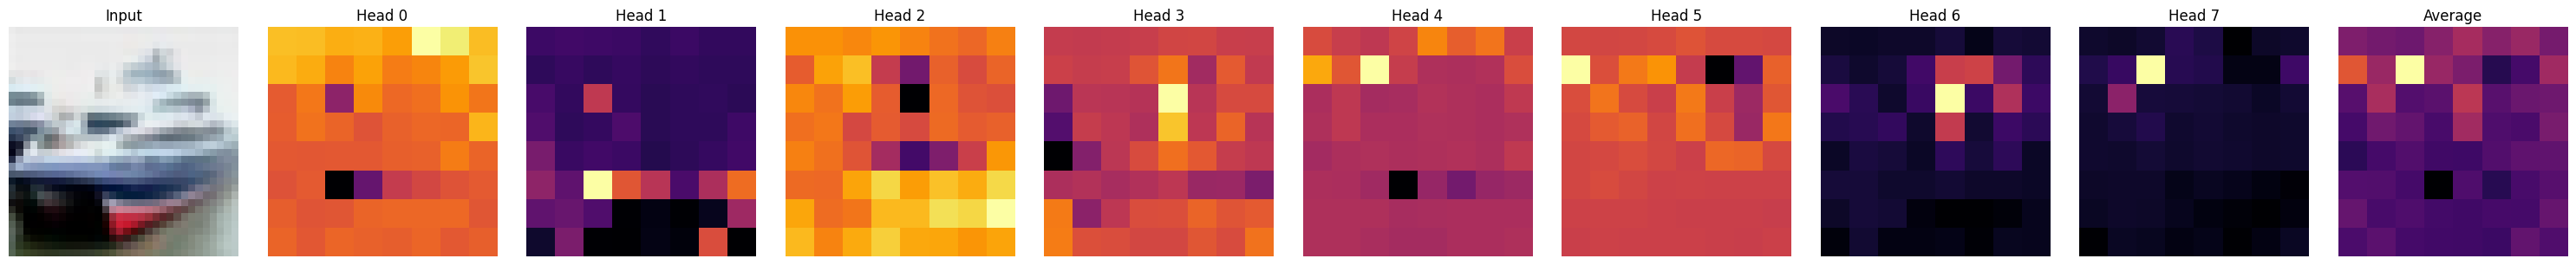

In [2]:
# ─── RAW DIFF‑ViT [CLS] → PATCH ATTENTION ────────────────────────
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# A. SETTINGS
MODEL_PATH = "/kaggle/input/cv-assgn-5-q2-2-hyp/best_model_diff_set1.pth"
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SZ   = 16

# B. DATA
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),
                         (0.2470,0.2435,0.2616)),
])
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SZ, shuffle=False, num_workers=2)

# C. LOAD DIFF‑ViT (must have class in scope)
model = DifferentialVisionTransformer(
    image_size=32, patch_size=4, in_channels=3,
    num_classes=10, d_model=192, num_heads=8,
    num_layers=8, dim_ff=768, dropout=0.1, lambda_init=0.5
)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE).eval()

# D. SET UP A PLACE TO STORE EACH HEAD’s DIFF‐ATTN MATRIX
n_layers = len(model.encoder_layers)
n_heads  = len(model.encoder_layers[0].attention.heads)
raw_attns = [ [None]*n_heads for _ in range(n_layers) ]

# E. HOOK TO RE‑COMPUTE diff_attn INSIDE DifferentialAttention
def make_hook(layer_idx, head_idx):
    def hook(module, inputs, outputs):
        x = inputs[0]  # [B, seq, d_model]
        # project
        q = module.q_proj(x)
        k = module.k_proj(x)
        v = module.v_proj(x)
        # split
        q1, q2 = q.chunk(2, dim=-1)
        k1, k2 = k.chunk(2, dim=-1)
        # scores
        s1 = (q1 @ k1.transpose(-2,-1)) * module.scale
        s2 = (q2 @ k2.transpose(-2,-1)) * module.scale
        # apply mask if any
        if len(inputs)>1 and inputs[1] is not None:
            m = inputs[1]
            s1 = s1.masked_fill(m==0, -1e9)
            s2 = s2.masked_fill(m==0, -1e9)
        # weights
        w1 = F.softmax(s1, dim=-1)
        w2 = F.softmax(s2, dim=-1)
        diff = w1 - module.lambda_val * w2   # [B, seq, seq]
        raw_attns[layer_idx][head_idx] = diff.detach().cpu()
    return hook

# F. REGISTER HOOKS
for li, enc in enumerate(model.encoder_layers):
    for hi, head in enumerate(enc.attention.heads):
        head.register_forward_hook(make_hook(li, hi))

# G. FORWARD ONE BATCH
imgs, _ = next(iter(test_loader))
imgs = imgs.to(DEVICE)
_    = model(imgs)

# H. PLOT LAST‐LAYER PER‐HEAD + AVERAGED [CLS→PATCH]
last = n_layers - 1
seq_len = raw_attns[last][0].shape[-1]
num_patches = seq_len - 1
grid_size   = int(np.sqrt(num_patches))

# build [heads, num_patches]
cls2patch = torch.stack([
    raw_attns[last][h][0, 0, 1:]  for h in range(n_heads)
], dim=0)

# undo CIFAR‑10 norm
img = imgs[1].cpu().permute(1,2,0).numpy()
mean = np.array([0.4914,0.4822,0.4465])
std  = np.array([0.2470,0.2435,0.2616])
img = np.clip(img*std + mean, 0, 1)

fig, axes = plt.subplots(1, n_heads+2, figsize=(3*(n_heads+2),3))
axes[0].imshow(img); axes[0].set_title("Input"); axes[0].axis('off')

for h in range(n_heads):
    m = cls2patch[h].reshape(grid_size,grid_size).numpy()
    ax = axes[h+1]
    ax.imshow(m, cmap='inferno'); ax.set_title(f"Head {h}"); ax.axis('off')

avg = cls2patch.mean(0).reshape(grid_size,grid_size).numpy()
axes[-1].imshow(avg, cmap='inferno'); axes[-1].set_title("Average"); axes[-1].axis('off')
plt.tight_layout(); plt.show()


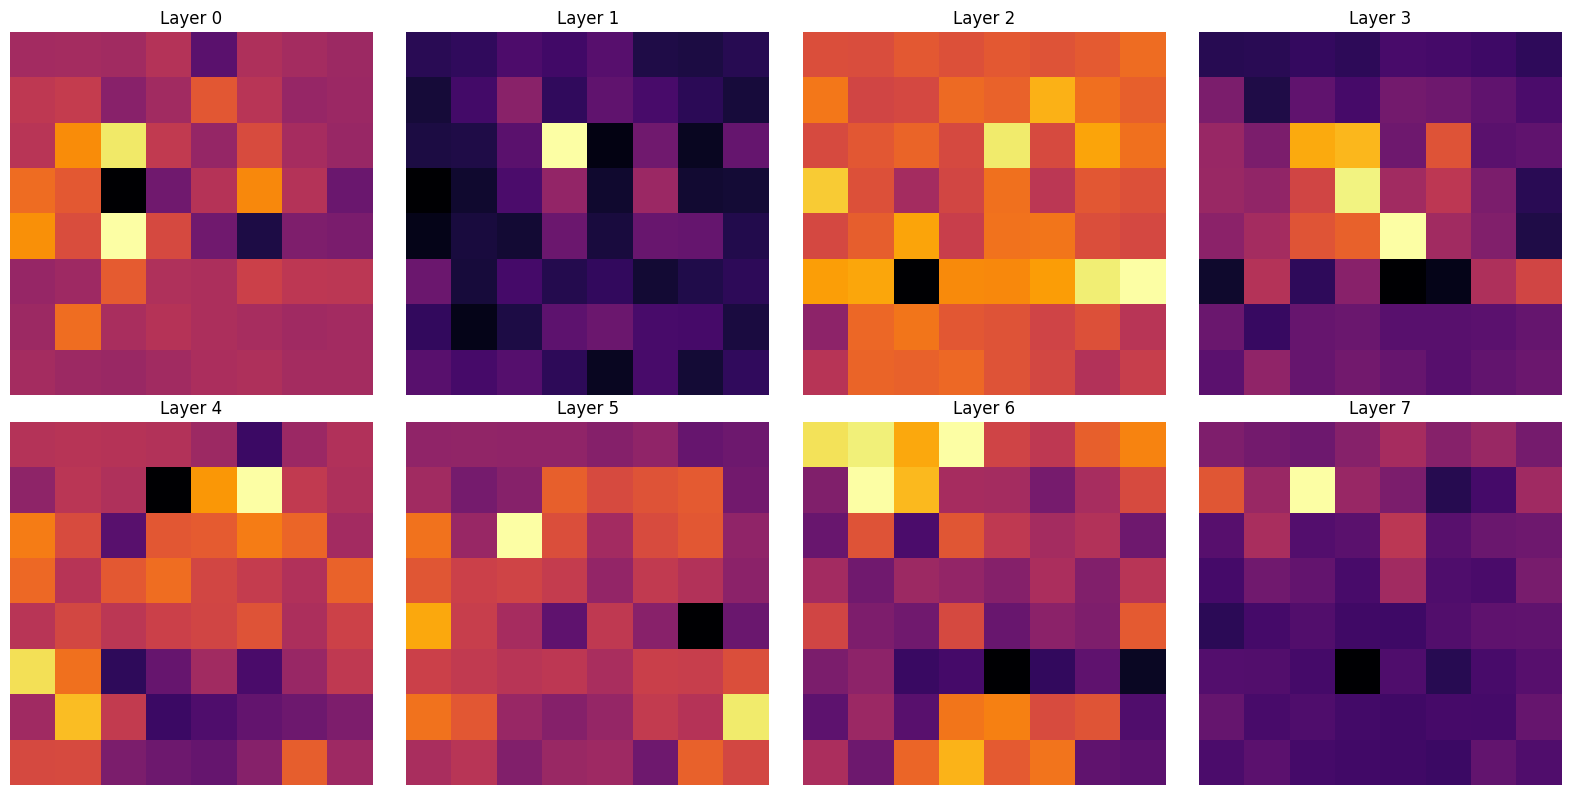

In [3]:
# ─── ALL‑LAYERS [CLS→PATCH] AGGREGATED HEATMAPS ─────────────────
import torch, math, numpy as np, matplotlib.pyplot as plt

# raw_attns[layer_idx][head_idx] holds a tensor of shape [B, seq, seq]
# from Cell 1, and n_layers is the number of encoder layers.

# 1. compute sizes
seq_len     = raw_attns[0][0].shape[-1]         # seq = 1 + num_patches
num_patches = seq_len - 1
grid_size   = int(np.sqrt(num_patches))
batch_i     = 0                                 # visualize image 0 in the batch

# 2. build one aggregated vector per layer
agg_maps = []
for layer_idx in range(n_layers):
    # stack all heads → [heads, B, seq, seq]
    layer_stack = torch.stack(raw_attns[layer_idx], dim=0)
    # select this image in batch → [heads, seq, seq]
    heads_map   = layer_stack[:, batch_i]
    # mean over heads → [seq, seq]
    mean_map    = heads_map.mean(dim=0)
    # take CLS→patch slice → [num_patches]
    cls2patch   = mean_map[0, 1:]
    agg_maps.append(cls2patch)

# 3. plot in a rows×cols grid
cols = 4
rows = math.ceil(n_layers / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

for idx in range(n_layers):
    r, c = divmod(idx, cols)
    ax   = axes[r][c]
    m    = agg_maps[idx].reshape(grid_size, grid_size).numpy()
    ax.imshow(m, cmap='inferno', interpolation='nearest')
    ax.set_title(f"Layer {idx}")
    ax.axis('off')

# turn off any leftover axes
for idx in range(n_layers, rows*cols):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()


# 2.3.2

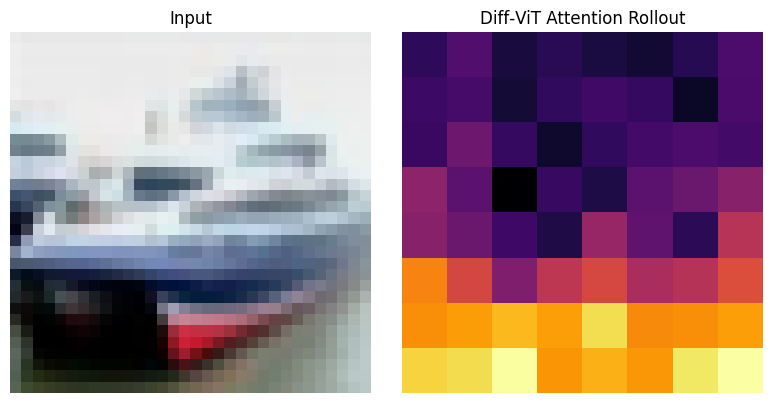

In [4]:
# ─── DIFF‑ViT ATTENTION‑ROLLOUT ─────────────────────────────────
import torch, numpy as np, matplotlib.pyplot as plt

# A. (Re‑)RUN the forward to refresh raw_attns
_ = model(imgs)

# B. STACK into per‐layer tensors [heads, seq, seq]
raw_per_layer = [
    torch.stack(raw_attns[l], dim=0)   # → [heads, seq, seq]
    for l in range(n_layers)
]

# C. ROLLOUT
batch_i = 0
joint   = torch.eye(raw_per_layer[0].shape[-1])
for A in raw_per_layer:
    # mean over heads
    M = A[batch_i].mean(0)            # [seq, seq]
    # add residual, renormalize
    M = M + torch.eye(M.size(0))
    M = M / M.sum(-1, keepdim=True)
    joint = M @ joint

roll = joint[0,1:]                    # [num_patches]
g    = int(np.sqrt(roll.shape[0]))
roll_map = roll.reshape(g, g).numpy()

# D. PLOT
fig, (a0,a1) = plt.subplots(1,2, figsize=(8,4))
a0.imshow(img); a0.set_title("Input"); a0.axis('off')
a1.imshow(roll_map, cmap='inferno', interpolation='nearest')
a1.set_title("Diff‑ViT Attention Rollout"); a1.axis('off')
plt.tight_layout(); plt.show()
